<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/TheThematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map

Last session we created a file with several layers:

In [104]:
import geopandas as gpd

linkGit='https://github.com/CienciaDeDatosEspacial/dataSets/raw/main/'
linkWorldMaps='WORLD/worldMaps.gpkg'

we can easily find out the layers in that geopackage file (**worldMaps.gpkg**):

In [105]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


For the thematics we will retrieve only one layer (map):

In [106]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


As you see, the GDF above has just two colums; enough to plot a map, but no more than that.

Let me open a DF:

In [107]:
import pandas as pd

someDataLink='WORLD/some_dataworld.csv'

someData=pd.read_csv(linkGit+someDataLink)

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       172 non-null    object 
 1   iso2          171 non-null    object 
 2   iso3          172 non-null    object 
 3   region        172 non-null    object 
 4   fragility     172 non-null    float64
 5   co2           172 non-null    int64  
 6   sq_km         172 non-null    int64  
 7   num_airports  172 non-null    int64  
 8   population    172 non-null    int64  
 9   mobiles       172 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 13.6+ KB


## Pre Processing: Merging

The DF has some interesting numerical data (_float64_):
* fragility: fragility index 2023 -[details here](https://fragilestatesindex.org/2023/06/14/fragile-states-index-2023-annual-report/)
* co2: metric tonnes of CO2 emmitted -[details here](https://www.cia.gov/the-world-factbook/field/carbon-dioxide-emissions/country-comparison/)
* sq_km: country area -[details here](https://www.cia.gov/the-world-factbook/field/area/country-comparison/)
* num_airports: count of airports in the country -[details here](https://www.cia.gov/the-world-factbook/field/airports/country-comparison/)
* population: country population  -[details here](https://www.cia.gov/the-world-factbook/field/population/country-comparison/)
* mobiles: total number of mobile cellular telephone subscribers -[details here](https://www.cia.gov/the-world-factbook/field/telephones-mobile-cellular/country-comparison/)

There are also other columns that may be of help:

In [108]:
someData.head()

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles
0,AFGHANISTAN,AF,AFG,SOUTH ASIA,105.0,7893000,652230,68,40121552,23000000
1,ALBANIA,AL,ALB,EUROPE,58.9,3794000,28748,3,3107100,2610000
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000
3,ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000
4,ANTIGUA AND BARBUDA,AG,ATG,CENTRAL AMERICA AND THE CARIBBEAN,54.4,729000,443,4,102634,184000


Preparing thematic maps requires **social data** _about_ the geometry (line, polygon, point). The object **countries** has no social data, so the preprocessing requires geomerging.

### Geo Merging

This is a critical preprocessing operation, as it is in charge of combining data sets, in this case combine a DF into a GDF. Some rules are needed:

* There is at least one common column needed to serve for the matches.
* The common columns, or KEYs, need contents to be written exactly in both columns.
* It is recommended that both KEYs are named the same.

Here we have the KEYs:

In [109]:
countries.COUNTRY.head()

0    Aruba (Netherlands)
1    Antigua and Barbuda
2            Afghanistan
3                Algeria
4             Azerbaijan
Name: COUNTRY, dtype: object

In [110]:
someData.Country.head()

0            AFGHANISTAN
1                ALBANIA
2                ALGERIA
3                 ANGOLA
4    ANTIGUA AND BARBUDA
Name: Country, dtype: object

Let's solve the _country name_ differences for the KEYs:

In [111]:
countries.rename(columns={'COUNTRY':'Country'},inplace=True)

We can notice the different *case* in the KEYs. Let's work with uppercases:

In [112]:
countries['Country']=countries.Country.str.upper()

It is very unlikely the names are written the same. Let's verify:

In [113]:
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

Check here:

In [114]:
onlyDF # they did not find a match in the MAP GDF!

{'BAHAMAS (THE)',
 'BOLIVIA (PLURINATIONAL STATE OF)',
 'BRUNEI DARUSSALAM',
 'CABO VERDE',
 'CENTRAL AFRICAN REPUBLIC (THE)',
 'COMOROS (THE)',
 'CONGO (THE DEMOCRATIC REPUBLIC OF THE)',
 'CONGO (THE)',
 "CÔTE D'IVOIRE",
 'DOMINICAN REPUBLIC (THE)',
 'ESWATINI',
 'GAMBIA (THE)',
 'IRAN (ISLAMIC REPUBLIC OF)',
 'KOREA (THE REPUBLIC OF)',
 "LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
 'MICRONESIA (FEDERATED STATES OF)',
 'MOLDOVA (THE REPUBLIC OF)',
 'NETHERLANDS (THE)',
 'NIGER (THE)',
 'NORTH MACEDONIA',
 'NORTHERN MARIANA ISLANDS (THE)',
 'PHILIPPINES (THE)',
 'RUSSIAN FEDERATION (THE)',
 'SAMOA',
 'SUDAN (THE)',
 'TANZANIA, THE UNITED REPUBLIC OF',
 'TIMOR-LESTE',
 'UNITED ARAB EMIRATES (THE)',
 'UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND (THE)',
 'UNITED STATES OF AMERICA (THE)'}

There are several countries in the DF that did not find a match in the GDF (map). Of course, most of them are in the map, let's see why they were not matched.

### Fuzzy merging

We use this technique to detect similarities between strings. You need this package **thefuzz** (based on the [Levenshtein algorithm](https://en.wikipedia.org/wiki/Levenshtein_distance)):

In [115]:
!pip install thefuzz

This is the basic idea:

In [116]:
from thefuzz.process import extractOne as best

## find the BEST match to 'BAHAMAS (THE)'
## from all strings in 'onlyGDF'

best('BAHAMAS (THE)',onlyGDF)

('BAHAMAS', 90)

As you see, you get a coefficient value of 90 (the closer to 100 the better). That may be a reliable result.

Let's do the same for all the unmatched countries:

In [117]:
## for each country in onlyDF, find the BEST match in onlyGDF

[(country, best(country,onlyGDF)) for country in onlyDF]

[('IRAN (ISLAMIC REPUBLIC OF)', ('IRAN', 90)),
 ('CONGO (THE)', ('CONGO', 90)),
 ('BOLIVIA (PLURINATIONAL STATE OF)', ('BOLIVIA', 90)),
 ('NIGER (THE)', ('NIGER', 90)),
 ('NORTH MACEDONIA', ('MACEDONIA', 90)),
 ('NORTHERN MARIANA ISLANDS (THE)', ('NORTHERN MARIANA ISLANDS (US)', 91)),
 ('CONGO (THE DEMOCRATIC REPUBLIC OF THE)',
  ('DEMOCRATIC REPUBLIC OF THE CONGO', 95)),
 ('UNITED ARAB EMIRATES (THE)', ('UNITED ARAB EMIRATES', 95)),
 ('BAHAMAS (THE)', ('BAHAMAS', 90)),
 ('RUSSIAN FEDERATION (THE)', ('RUSSIA', 90)),
 ('UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND (THE)',
  ('UNITED KINGDOM', 90)),
 ('TIMOR-LESTE', ('EAST TIMOR', 81)),
 ('TANZANIA, THE UNITED REPUBLIC OF', ('TANZANIA', 90)),
 ("CÔTE D'IVOIRE", ('IVORY COAST', 58)),
 ('BRUNEI DARUSSALAM', ('BRUNEI', 90)),
 ('DOMINICAN REPUBLIC (THE)', ('DOMINICAN REPUBLIC', 95)),
 ('CENTRAL AFRICAN REPUBLIC (THE)', ('CENTRAL AFRICAN REPUBLIC', 95)),
 ('KOREA (THE REPUBLIC OF)', ('SOUTH KOREA', 86)),
 ('COMOROS (THE)', ('COMOROS',

Each element in the *list* above in in parentheses, for instance:

```
('TIMOR-LESTE', ('EAST TIMOR', 81))
```

That element has two elements:


*   **'TIMOR-LESTE'** from *onlyDF*, and
*   **('EAST TIMOR', 81)** which is the result from _best(country,onlyGDF)_. This last element, as we just saw above, shows the best match and the level of similarity (the higher the more similar).

We can prepare a list where each element has three elements:



In [118]:
#or
[(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]

[('IRAN (ISLAMIC REPUBLIC OF)', 'IRAN', 90),
 ('CONGO (THE)', 'CONGO', 90),
 ('BOLIVIA (PLURINATIONAL STATE OF)', 'BOLIVIA', 90),
 ('NIGER (THE)', 'NIGER', 90),
 ('NORTH MACEDONIA', 'MACEDONIA', 90),
 ('NORTHERN MARIANA ISLANDS (THE)', 'NORTHERN MARIANA ISLANDS (US)', 91),
 ('CONGO (THE DEMOCRATIC REPUBLIC OF THE)',
  'DEMOCRATIC REPUBLIC OF THE CONGO',
  95),
 ('UNITED ARAB EMIRATES (THE)', 'UNITED ARAB EMIRATES', 95),
 ('BAHAMAS (THE)', 'BAHAMAS', 90),
 ('RUSSIAN FEDERATION (THE)', 'RUSSIA', 90),
 ('UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND (THE)',
  'UNITED KINGDOM',
  90),
 ('TIMOR-LESTE', 'EAST TIMOR', 81),
 ('TANZANIA, THE UNITED REPUBLIC OF', 'TANZANIA', 90),
 ("CÔTE D'IVOIRE", 'IVORY COAST', 58),
 ('BRUNEI DARUSSALAM', 'BRUNEI', 90),
 ('DOMINICAN REPUBLIC (THE)', 'DOMINICAN REPUBLIC', 95),
 ('CENTRAL AFRICAN REPUBLIC (THE)', 'CENTRAL AFRICAN REPUBLIC', 95),
 ('KOREA (THE REPUBLIC OF)', 'SOUTH KOREA', 86),
 ('COMOROS (THE)', 'COMOROS', 90),
 ('MOLDOVA (THE REPUBLIC OF

For instace, this element has 3 elements:

```
 ('IRAN (ISLAMIC REPUBLIC OF)', 'IRAN', 90)
```

The level of similarity would guide us to make update (replace) the strings in one of the KEYs, so that the merging process works properly.

Then, it would be better if we have a data frame instead of a list:

In [119]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF])

,0,1,2
0,IRAN (ISLAMIC REPUBLIC OF),IRAN,90
1,CONGO (THE),CONGO,90
2,BOLIVIA (PLURINATIONAL STATE OF),BOLIVIA,90
3,NIGER (THE),NIGER,90
4,NORTH MACEDONIA,MACEDONIA,90
5,NORTHERN MARIANA ISLANDS (THE),NORTHERN MARIANA ISLANDS (US),91
6,CONGO (THE DEMOCRATIC REPUBLIC OF THE),DEMOCRATIC REPUBLIC OF THE CONGO,95
7,UNITED ARAB EMIRATES (THE),UNITED ARAB EMIRATES,95
8,BAHAMAS (THE),BAHAMAS,90
9,RUSSIAN FEDERATION (THE),RUSSIA,90


Let's sort by the column '2' (the third):

In [120]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(by=2)

,0,1,2
13,CÔTE D'IVOIRE,IVORY COAST,58
20,ESWATINI,MARTINIQUE (FRANCE),60
24,CABO VERDE,CAPE VERDE,80
11,TIMOR-LESTE,EAST TIMOR,81
17,KOREA (THE REPUBLIC OF),SOUTH KOREA,86
27,LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE),CENTRAL AFRICAN REPUBLIC,86
0,IRAN (ISLAMIC REPUBLIC OF),IRAN,90
1,CONGO (THE),CONGO,90
10,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,UNITED KINGDOM,90
12,"TANZANIA, THE UNITED REPUBLIC OF",TANZANIA,90


The previous result helps make a plan based on these cases:
* **ESWATINI** is always a problem, because it is also *SWAZILAND*.
* **KOREA (THE REPUBLIC OF)** is not _NORTH KOREA_.
* **LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)** is too long to match *LAOS* (if it exists in the map like that).
* **SAMOA** is always a problem, because it is also *WESTERN SAMOA*.

Based on this, we should see what our GDF has:

In [121]:
countries.Country[countries.Country.str.contains('SWAZ|LAO|SAMOA|KORE')]

9      AMERICAN SAMOA (US)
120            NORTH KOREA
122            SOUTH KOREA
126                   LAOS
242          WESTERN SAMOA
243              SWAZILAND
Name: Country, dtype: object

Then, it makes sense to change those manually (notice the 'replace' uses Python dictionaries):

In [122]:
# this is a {dictionary}

manualChanges={'SWAZILAND':'ESWATINI',
               'LAOS':"LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
               'SOUTH KOREA':'KOREA (THE REPUBLIC OF)',
               'WESTERN SAMOA':'SAMOA',
              }

countries.replace(to_replace={'Country':manualChanges},inplace=True)

At this stage, we should recompute the differences:

In [123]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

An re run this code:

In [124]:
# keeping high scores

pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(2)

,0,1,2
13,CÔTE D'IVOIRE,IVORY COAST,58
22,CABO VERDE,CAPE VERDE,80
11,TIMOR-LESTE,EAST TIMOR,81
0,IRAN (ISLAMIC REPUBLIC OF),IRAN,90
4,NORTH MACEDONIA,MACEDONIA,90
9,RUSSIAN FEDERATION (THE),RUSSIA,90
2,BOLIVIA (PLURINATIONAL STATE OF),BOLIVIA,90
1,CONGO (THE),CONGO,90
10,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,UNITED KINGDOM,90
12,"TANZANIA, THE UNITED REPUBLIC OF",TANZANIA,90


All this is correct now!

Let's prepare the changes:

In [125]:
# new {dictionary}
changesToDF={country: best(country,onlyGDF)[0] for country in onlyDF}
changesToDF

{'IRAN (ISLAMIC REPUBLIC OF)': 'IRAN',
 'CONGO (THE)': 'CONGO',
 'BOLIVIA (PLURINATIONAL STATE OF)': 'BOLIVIA',
 'NIGER (THE)': 'NIGER',
 'NORTH MACEDONIA': 'MACEDONIA',
 'NORTHERN MARIANA ISLANDS (THE)': 'NORTHERN MARIANA ISLANDS (US)',
 'CONGO (THE DEMOCRATIC REPUBLIC OF THE)': 'DEMOCRATIC REPUBLIC OF THE CONGO',
 'UNITED ARAB EMIRATES (THE)': 'UNITED ARAB EMIRATES',
 'BAHAMAS (THE)': 'BAHAMAS',
 'RUSSIAN FEDERATION (THE)': 'RUSSIA',
 'UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND (THE)': 'UNITED KINGDOM',
 'TIMOR-LESTE': 'EAST TIMOR',
 'TANZANIA, THE UNITED REPUBLIC OF': 'TANZANIA',
 "CÔTE D'IVOIRE": 'IVORY COAST',
 'BRUNEI DARUSSALAM': 'BRUNEI',
 'DOMINICAN REPUBLIC (THE)': 'DOMINICAN REPUBLIC',
 'CENTRAL AFRICAN REPUBLIC (THE)': 'CENTRAL AFRICAN REPUBLIC',
 'COMOROS (THE)': 'COMOROS',
 'MOLDOVA (THE REPUBLIC OF)': 'MOLDOVA',
 'SUDAN (THE)': 'SUDAN',
 'GAMBIA (THE)': 'GAMBIA',
 'MICRONESIA (FEDERATED STATES OF)': 'FEDERATED STATES OF MICRONESIA',
 'CABO VERDE': 'CAPE VERDE',

In [126]:
someData.replace(to_replace={'Country':changesToDF},inplace=True)

What is left to match?

In [127]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)
[(country, best(country,onlyGDF)) for country in onlyDF]

[]

Once you are here, merging can proceed:

In [128]:
## GDF to the 'left'
theMapAndData=countries.merge(someData, on='Country')

And our GDF has social data now!

In [129]:
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Country       172 non-null    object  
 1   geometry      172 non-null    geometry
 2   iso2          171 non-null    object  
 3   iso3          172 non-null    object  
 4   region        172 non-null    object  
 5   fragility     172 non-null    float64 
 6   co2           172 non-null    int64   
 7   sq_km         172 non-null    int64   
 8   num_airports  172 non-null    int64   
 9   population    172 non-null    int64   
 10  mobiles       172 non-null    int64   
dtypes: float64(1), geometry(1), int64(5), object(4)
memory usage: 14.9+ KB


We should save this map of countries and their indicators in a new file:

In [130]:
theMapAndData.to_file("worldindicators.json")

# Thematics: the DDM (Dot Density Map)

You have a DDM if you use dot to show comparatively which polygon of a map has 'more' (or 'less') of some countable phenomenon of interest.
A dot is an aggregated value, but it is constant for each dot.

We have the world map, let's keep Africa:

In [131]:
theMapAndData.region.value_counts()

region
AFRICA                               52
EUROPE                               37
MIDDLE EAST                          16
CENTRAL AMERICA AND THE CARIBBEAN    16
EAST AND SOUTHEAST ASIA              15
SOUTH AMERICA                        12
SOUTH ASIA                            8
AUSTRALIA AND OCEANIA                 7
CENTRAL ASIA                          6
NORTH AMERICA                         3
Name: count, dtype: int64

### Preprocessing: Filtering

<Axes: >

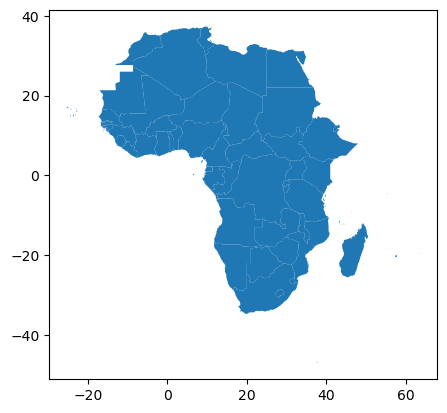

In [132]:
# then

Africa=theMapAndData[theMapAndData.region=='AFRICA']
Africa.plot()

A DDM can serve as an effective way to show the distribution of people. The most critical tasks are:

* Dot Placement: The dots should be randomly distributed within each polygon to avoid misrepresenting the data.

* Dot Unit: Deciding how many people each dot should represent is key for visual clarity. This value should be chosen carefully to avoid oversaturation or sparsity.

The size of all dots on the map must be the same to ensure a consistent visual comparison.

### Preprocessing: aggregating

This is a DOT UNIT proposal:

In [133]:
justDots=Africa.copy()
dot_value = 100000
justDots['num_dots'] = (justDots['population'] / dot_value).astype(int)

### Preprocessing: distributing dots

And here, we get a location for the dots:

In [134]:
# 2. Generate the random dot locations using .sample_points()
justDots = justDots.sample_points(size=justDots['num_dots']).explode(index_parts=True)

You get this:

In [135]:
justDots

2    0        POINT (-8.233 27.29615)
     1      POINT (-8.02889 28.58198)
     2       POINT (-7.5223 28.17401)
     3      POINT (-7.44313 28.27179)
     4      POINT (-7.43006 27.18732)
                      ...            
169  122     POINT (34.53922 5.61195)
     123     POINT (34.73092 6.03961)
     124     POINT (34.90283 4.95567)
     125     POINT (35.35726 5.00434)
     126     POINT (35.70726 5.22923)
Name: sampled_points, Length: 14634, dtype: geometry

In [136]:
# what is it?
type(justDots)

geopandas.geoseries.GeoSeries

### Preprocessing: building GDF from GS

Notice the multi index (MI), one for a country and for a dot. As we are planing to send these points to R, we avoid MI:

In [137]:
justDots.reset_index(drop=True, inplace=True)
Africa_dots=gpd.GeoDataFrame(geometry=justDots)
Africa_dots

,geometry
0,POINT (-8.233 27.29615)
1,POINT (-8.02889 28.58198)
2,POINT (-7.5223 28.17401)
3,POINT (-7.44313 28.27179)
4,POINT (-7.43006 27.18732)
...,...
14629,POINT (34.53922 5.61195)
14630,POINT (34.73092 6.03961)
14631,POINT (34.90283 4.95567)
14632,POINT (35.35726 5.00434)


Now you have a GDF:

In [138]:
Africa_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14634 non-null  geometry
dtypes: geometry(1)
memory usage: 114.5 KB


Juts plot the polygons as the base, and the points as the layer on top!

<Axes: >

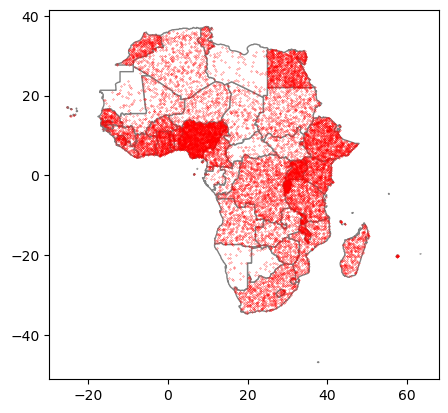

In [139]:
base=Africa.plot(facecolor="white",#color of polygon fill
               edgecolor='grey') #color of border
Africa_dots.plot(markersize=0.05, color='red',ax=base)

It is generally recommended that DDMs use an **equal-area projection**, which benefits density and limits area distortion.

<Axes: >

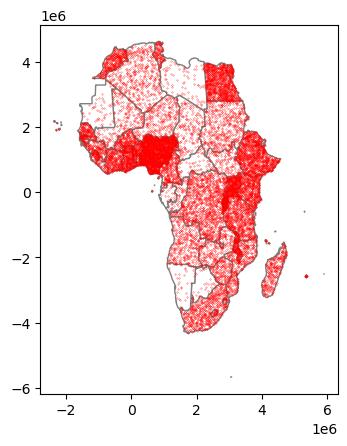

In [140]:
base=Africa.to_crs(8857).plot(facecolor="white",
                              edgecolor='grey')
Africa_dots.to_crs(8857).plot(markersize=0.05, color='red',ax=base)

Let's keep the continent countries with that crs:

In [141]:
Africa_8857=Africa.to_crs(8857)
Africa_dots_8857=Africa_dots.to_crs(8857)

# Thematics: the PSM (Proportional Symbol Map)

You have a PSM if you use a symbol (generally a circle) to show the distribution of a variable per location.
The symbol is an aggregated raw value, and its size varies according to those values. So now we need:

### Preprocessing: GDF of centroids

1. A location for a symbol, generally the polygon centroid.

In [142]:
Africa_8857_centroids = Africa_8857.copy()

# Africa_8857_centroids will have a new geometry:
Africa_8857_centroids['geometry'] = Africa_8857_centroids['geometry'].centroid

2. A size of varying values (not constant as in DDMs). Let's use population again.

In [143]:
Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: x**0.5/100)

## or
# import numpy as np
# Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: np.log10(x))

We got the basics, then:

<Axes: >

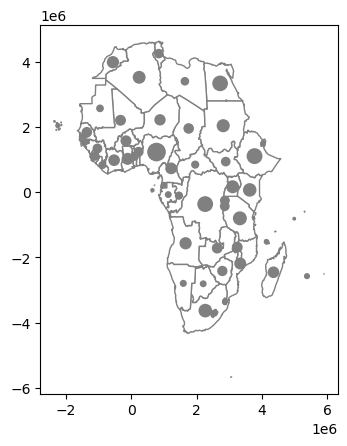

In [144]:
base=Africa_8857.plot(facecolor="white",
                      edgecolor='grey')
# Plot the centroids on top
Africa_8857_centroids.plot(
    ax=base,
    markersize=Africa_8857_centroids['size'],
    color='grey'
)

In [145]:
!pip install matplotlib

In [146]:
!pip install mapclassify

In [147]:
!pip install "folium>=0.12" matplotlib mapclassify

Keep in mind that the standard way of computing centroids may bring some trouble. Let´s plot Seychelles:

In [148]:
base=Africa_8857[Africa_8857.Country=="SEYCHELLES"].explore()
Africa_8857_centroids[Africa_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

A good alternative to centroids is representative_point() when dealing with complex multipolygons.

In [149]:
# replace the points
Africa_8857_centroids["geometry"]=Africa_8857.representative_point()

We will keep that last result.

In [150]:
base=Africa_8857[Africa_8857.Country=="SEYCHELLES"].explore()
Africa_8857_centroids[Africa_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

### Preprocessing: Computing new columns

PPMs are not thematic maps to see precise values, but to reveal clear differences on the variable distribution used. As, human eyes are very limited to detect area differences, we may need to use some other tactics to help uncover some patterns.

For example, let's confirm if we have outliers:

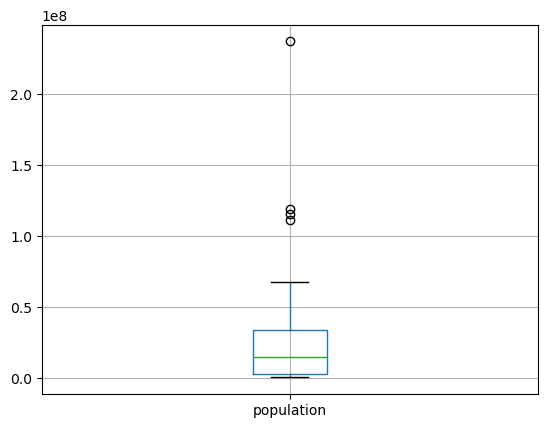

In [151]:
boxplotInfo=Africa_8857_centroids.boxplot(column='population',return_type="dict")

The object **boxplotInfo** showed the boxplot, and we confirm there are outliers. We can recover them like this:

In [152]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([115403027, 111247248, 118550298, 236747130], dtype=object)

Then, these are the outlying countries:

In [153]:
Africa_8857_centroids[Africa_8857_centroids.population.isin(outliers)]

,Country,geometry,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,size
32,DEMOCRATIC REPUBLIC OF THE CONGO,POINT (2150454.367 -516111.79),CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,107.425801
48,EGYPT,POINT (2678759.188 3375702.424),EG,EGY,AFRICA,88.4,235137000,1001450,73,111247248,106000000,105.473811
53,ETHIOPIA,POINT (3713238.555 1171240.545),ET,ETH,AFRICA,94.2,16798000,1104300,58,118550298,71400000,108.880805
112,NIGERIA,POINT (754640.377 1162553.003),NG,NGA,AFRICA,98.5,104494000,923768,50,236747130,224000000,153.865893


Knowing this information, we can create a column as outlier flag:

In [154]:
Africa_8857_centroids['population_outlier']=Africa_8857_centroids.population.isin(outliers)*1

## see
Africa_8857_centroids

,Country,geometry,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,size,population_outlier
2,ALGERIA,POINT (58149.408 3504624.452),DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,68.572934,0
6,ANGOLA,POINT (1789934.856 -1524650.389),AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,60.993492,0
12,BOTSWANA,POINT (2262432.346 -2828174.988),BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,15.654610,0
19,BENIN,POINT (219186.939 1191134.38),BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,38.336734,0
26,BURUNDI,POINT (2865100.606 -433659.14),BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,36.864756,0
29,CHAD,POINT (1747642.958 1965809.757),TD,TCD,AFRICA,108.5,1771000,1284000,44,19093595,12100000,43.696218,0
31,CONGO,POINT (1540711.045 -82846.788),CG,COG,AFRICA,92.5,4523000,342000,56,6097665,5870000,24.693451,0
32,DEMOCRATIC REPUBLIC OF THE CONGO,POINT (2150454.367 -516111.79),CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,107.425801,1
35,CAMEROON,POINT (1299556.828 944934.755),CM,CMR,AFRICA,97.0,7105000,475440,37,30966105,26200000,55.647197,0
36,COMOROS,POINT (4208450.609 -1564478.31),KM,COM,AFRICA,81.7,326000,2235,3,900141,934000,9.487576,0


We can use that like this:

<Axes: >

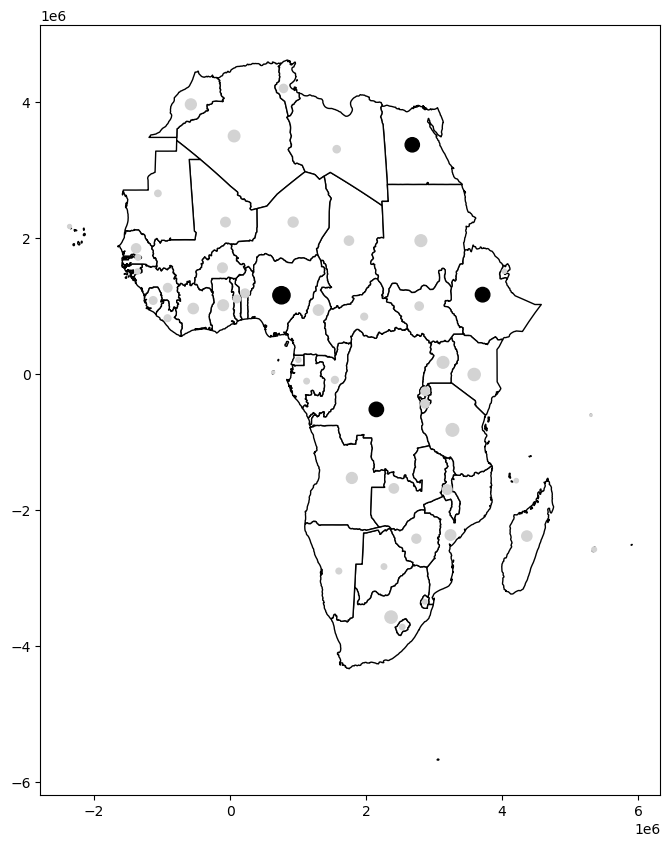

In [155]:
base = Africa_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Define your color map
mapcolor = {1: 'black', 0: 'lightgrey'}

# Plot the centroids on top
Africa_8857_centroids.plot(
    ax=base,
    markersize=Africa_8857_centroids['size'],
    color=Africa_8857_centroids['population_outlier'].map(mapcolor)
)

Here, we do a good job for outliers, but it is difficult to interprete the other ones. We could use some redundancy, but more work is needed:
1. Create two maps of centroids:

In [156]:
# Create explicit copies of the DataFrames
Africa_8857_centroids_out = Africa_8857_centroids[Africa_8857_centroids.population_outlier==1].copy()
Africa_8857_centroids_no_out = Africa_8857_centroids[Africa_8857_centroids.population_outlier==0].copy()


2. Compute sizes in each:

In [157]:
Africa_8857_centroids_out['size'] = Africa_8857_centroids_out['population'].apply(lambda x: x**0.5 / 50)
Africa_8857_centroids_no_out['size'] = Africa_8857_centroids_no_out['population'].apply(lambda x: x**0.5 / 50)

Now, plot the three layers, using some color gradient for the non-outliers:

<Axes: >

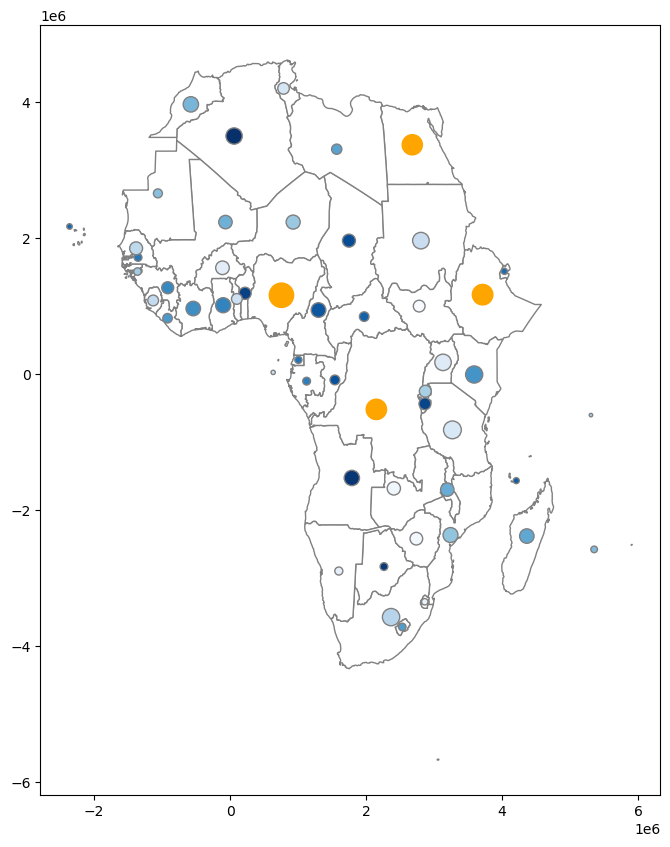

In [158]:
base=Africa_8857.plot(color='white', edgecolor='grey',figsize=(10,10))

Africa_8857_centroids_no_out.plot(
    ax=base,
    markersize=Africa_8857_centroids_no_out['size'],
    edgecolor='grey',
    c=Africa_8857_centroids_no_out['size'],
    cmap='Blues_r'
)
Africa_8857_centroids_out.plot(
    ax=base,
    markersize=Africa_8857_centroids_out['size'],
    color='orange'
)

# Thematics: Choropleths

Notice that the DDMs may use aggregated counts, and the PSMs use the variables in its original form. Choropleths will 'paint' the whole polygon and as noticed in PSMs, we have to be very careful when using color in shape, as the area itself is a confounding. To control this visual artifact, the variable must be normalized, that is, divided by a value correlated with the area.

Then, for this course, a choropleth is a normalized representation of data.

Following our definition:

* This is **NOT** a choropleth:


<Axes: >

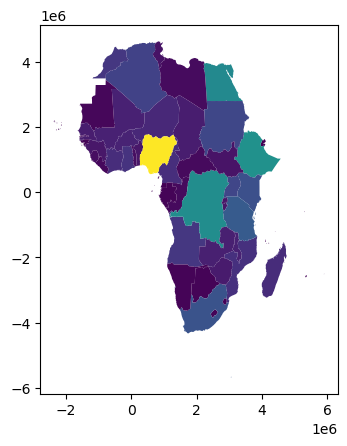

In [159]:
Africa_8857.plot(Africa_8857.population)

* This **IS** a choropleth:

<Axes: >

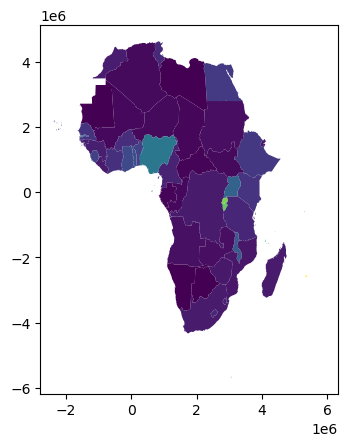

In [160]:
Africa_8857.plot(Africa_8857.population/Africa_8857.sq_km)

Choropleths are great to represent normalized indicators such as:
* Densities
* Ratios
* Rates
* Averages

Population by area is a density indicator. This is a real number (not an integer), so most of the time the color gradient might  not be
that useful to reveal some pattern visually. Then, we often discretize (or bin) the indicator computed.

### Preprocessing: Discretizing

Now, we want to cut the variable. Run the next code to make sure you have tose packages:

In [161]:
## do you have these installed?
# ! pip show numba mapclassify numpy

We will discretize this:

In [162]:
Africa_8857['population_density']=Africa_8857.population/Africa_8857.sq_km

Let's explore the bining algorithms:

In [163]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=Africa_8857['population_density']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

How can we select the right classification?
Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [164]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

Now, plot the **adcms**:

<Axes: ylabel='Classifier'>

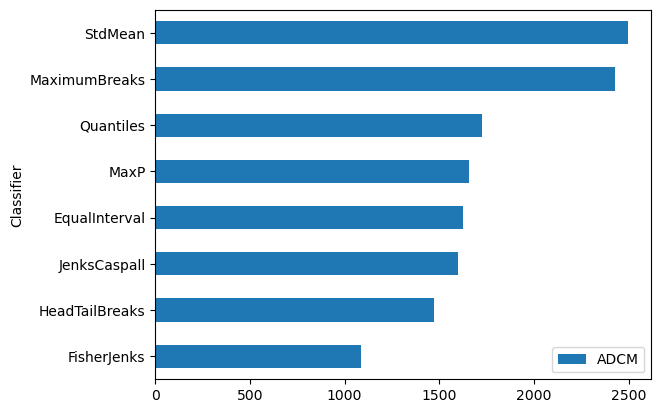

In [165]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

Let's save the best strategy:

In [166]:
Africa_8857['population_density_FJ5'] = fj5.yb

In [167]:
# there you are
Africa_8857[['population_density','population_density_FJ5']].head(20)

,population_density,population_density_FJ5
2,19.742908,0
6,29.840428,0
12,4.212724,0
19,130.498943,1
26,488.325620,3
29,14.870401,0
31,17.829430,0
32,49.215358,0
35,65.131468,0
36,402.747651,3


We could create a copy of the bins to add labels:

In [168]:
# renaming
newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

Africa_8857['population_density_FJ5_cat']=Africa_8857.loc[:,'population_density_FJ5'].replace(newLabelsForLevels)

# we have
Africa_8857[['population_density','population_density_FJ5','population_density_FJ5_cat']].head(20)

,population_density,population_density_FJ5,population_density_FJ5_cat
2,19.742908,0,0_VeryLow
6,29.840428,0,0_VeryLow
12,4.212724,0,0_VeryLow
19,130.498943,1,1_Low
26,488.325620,3,3_High
29,14.870401,0,0_VeryLow
31,17.829430,0,0_VeryLow
32,49.215358,0,0_VeryLow
35,65.131468,0,0_VeryLow
36,402.747651,3,3_High


We are ready for a discrete choropleth:

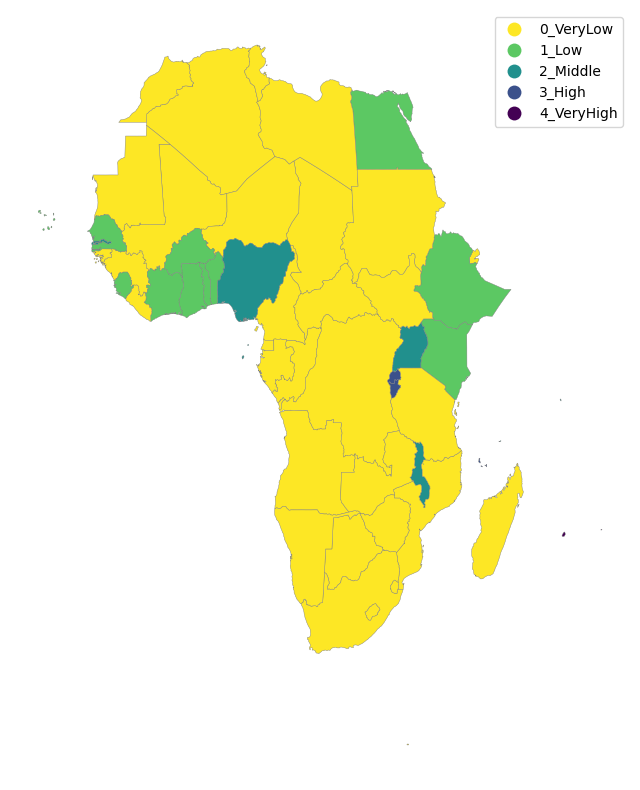

In [169]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
Africa_8857.plot(column='population_density_FJ5_cat', # variable to plot
                 cmap='viridis_r', # set of colors
                 categorical=True, # can be interpreted as category
                 edgecolor='grey', # border color
                 linewidth=0.3, # width of border
                 legend=True, # need a legend?
                 ax=ax
       )

ax.set_axis_off()

# Saving

Let's save this maps for R.

In [170]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_4
_18
theMapAndData
Africa
Africa_dots
_49
Africa_8857
Africa_dots_8857
Africa_8857_centroids
_60
_91
_106
_137
_153
_154
Africa_8857_centroids_out
Africa_8857_centroids_no_out


These are the ones needed in R:

In [171]:
# for choropleth and base map
Africa_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, 2 to 169
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Country                     52 non-null     object  
 1   geometry                    52 non-null     geometry
 2   iso2                        51 non-null     object  
 3   iso3                        52 non-null     object  
 4   region                      52 non-null     object  
 5   fragility                   52 non-null     float64 
 6   co2                         52 non-null     int64   
 7   sq_km                       52 non-null     int64   
 8   num_airports                52 non-null     int64   
 9   population                  52 non-null     int64   
 10  mobiles                     52 non-null     int64   
 11  population_density          52 non-null     float64 
 12  population_density_FJ5      52 non-null     int64   
 13  population_density

In [172]:
# for DDMs
Africa_dots_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14634 non-null  geometry
dtypes: geometry(1)
memory usage: 114.5 KB


In [173]:
# for PSMs
Africa_8857_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, 2 to 169
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             52 non-null     object  
 1   geometry            52 non-null     geometry
 2   iso2                51 non-null     object  
 3   iso3                52 non-null     object  
 4   region              52 non-null     object  
 5   fragility           52 non-null     float64 
 6   co2                 52 non-null     int64   
 7   sq_km               52 non-null     int64   
 8   num_airports        52 non-null     int64   
 9   population          52 non-null     int64   
 10  mobiles             52 non-null     int64   
 11  size                52 non-null     float64 
 12  population_outlier  52 non-null     int64   
dtypes: float64(2), geometry(1), int64(6), object(4)
memory usage: 5.7+ KB


In [174]:
# for PSMs
Africa_8857_centroids_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4 entries, 32 to 112
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             4 non-null      object  
 1   geometry            4 non-null      geometry
 2   iso2                4 non-null      object  
 3   iso3                4 non-null      object  
 4   region              4 non-null      object  
 5   fragility           4 non-null      float64 
 6   co2                 4 non-null      int64   
 7   sq_km               4 non-null      int64   
 8   num_airports        4 non-null      int64   
 9   population          4 non-null      int64   
 10  mobiles             4 non-null      int64   
 11  size                4 non-null      float64 
 12  population_outlier  4 non-null      int64   
dtypes: float64(2), geometry(1), int64(6), object(4)
memory usage: 448.0+ bytes


In [175]:
# for PSMs
Africa_8857_centroids_no_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 48 entries, 2 to 169
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             48 non-null     object  
 1   geometry            48 non-null     geometry
 2   iso2                47 non-null     object  
 3   iso3                48 non-null     object  
 4   region              48 non-null     object  
 5   fragility           48 non-null     float64 
 6   co2                 48 non-null     int64   
 7   sq_km               48 non-null     int64   
 8   num_airports        48 non-null     int64   
 9   population          48 non-null     int64   
 10  mobiles             48 non-null     int64   
 11  size                48 non-null     float64 
 12  population_outlier  48 non-null     int64   
dtypes: float64(2), geometry(1), int64(6), object(4)
memory usage: 5.2+ KB


The file **africa_8857.gpkg** will keep all those maps as layers!

In [176]:
Africa_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='continent')
Africa_dots_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='population_ddm')
Africa_8857_centroids.to_file("africa_8857.gpkg",driver='GPKG',layer='population_psm')
Africa_8857_centroids_out.to_file("africa_8857.gpkg",driver='GPKG',layer='outlier_population_psm')
Africa_8857_centroids_no_out.to_file("africa_8857.gpkg",driver='GPKG',layer='no_outlier_population_psm')

C:\Users\david\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Cannot find tms_NZTM2000.json (GDAL_DATA is not defined)
  ogr_write(
